In [502]:
# https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, TimeDistributed, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling1D
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from copy import copy
from tensorflow.keras import backend as K
from sklearn import preprocessing
import tensorflow.keras.optimizers as optimizers
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time

## Separate splits

In [504]:
def augument_sample(sample, averages, stds):
    return None

def format_data(df, lookback_window=12, only_features=False, to_drop=['total_cases'], lstm=False):
    x = []
    y = []
    x_data = df.copy()
    
    if only_features:
        x_data = x_data.drop(to_drop, axis=1)

    for i in range(len(df)-lookback_window):
        x_entry = copy(x_data[i:i+lookback_window].values.T) # include current value
        
        if not only_features:
            x_entry[0][lookback_window-1] = 0.0 # erase variable to be predicted
        
        if lstm:
            x.append(x_entry.T)
        else:
            x.append(x_entry)

        y_entry = df['total_cases'][i+lookback_window-1]
        y.append(y_entry)
        
    x = np.array(x)
    y = np.array(y)
    return x, y

In [505]:
def split(x, y, val_size):
    train_size = len(x)-val_size
    x_train, y_train = x[0:train_size], y[0:train_size]
    x_val, y_val = x[train_size:train_size+val_size], y[train_size:train_size+val_size]
    
    assert y_train.shape[0]+y_val.shape[0] == len(y)
    
    return x_train, y_train, x_val, y_val

## Model with Dense layers over time steps

In [507]:
def get_model_dense(input_shape):
    i = Input(shape=(input_shape))
    print(i.shape)
    m = i
    m = Dense(500, activation='relu')(m)
    m = BatchNormalization()(m)
    m = Dense(200, activation='relu')(m)
    m = Dense(1, activation='relu')(m)
    m = GlobalAveragePooling1D()(m)
    
    model = Model(inputs=[i], outputs=[m])

    optimizer=optimizers.Adam(lr=5e-6)
    model.compile(optimizer, 'mae')
    return model

## Model with TimeDistributed wrapper

In [555]:
def get_model_timedist(input_shape):
    i = Input(shape=(input_shape))
    print(i.shape)
    m = i
    m = TimeDistributed(Dense(500, activation='relu'))(m)
    m = BatchNormalization()(m)
    m = TimeDistributed(Dense(200, activation='relu'))(m)
    m = TimeDistributed(Dense(1, activation='relu'))(m)
    m = GlobalAveragePooling1D()(m) #avg pool or m =  Flatten()(m) m = Dense(1, activation='relu')(m)
    
    model = Model(inputs=[i], outputs=[m])

    optimizer=optimizers.Adam(lr=5e-6)
    model.compile(optimizer, 'mae')
    return model

In [536]:
def train_model(model, data, epochs=200, plot=True):
    start_time = time.time()
    print('Training...')
    x_train, y_train, x_val, y_val = data
    validation_data = (x_val, y_val)
    history = model.fit(x_train, y_train, epochs=epochs,
                        verbose=2, validation_data=validation_data, batch_size=50)
    elapsed_time = time.time() - start_time
    
    print("Elapsed Time: {}".format(elapsed_time))
    
    if plot:
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='validation')
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.ylim(0, 40)
        plt.legend(loc='upper right')
        plt.show()

In [520]:
def plot_train_val(model, data):
    x_train, y_train, x_val, y_val = data
    p = model.predict(x_train)
    plt.plot(y_train, label='actual')
    plt.plot(p, label='predicted')
    plt.title('Weekly Dengue Cases')
    plt.legend()
    plt.show()

    p = model.predict(x_val)
    plt.plot(y_val, label='actual')
    plt.plot(p, label='predicted')
    plt.title('Weekly Dengue Cases')
    plt.legend()
    plt.show()

## Forecasting

In [521]:
def forecast(model, forecast_window, last_train, test_data):
    lookback_window = last_train.shape[1]
    current = np.expand_dims(last_train, axis=0)
    next_y = model.predict(current)[0][0]
    current[0][0][-1] = next_y
    
    result = []
    for xi in test_data:
        xi[0][0:lookback_window] = current[0][0][-lookback_window:]
        current = np.expand_dims(xi, axis=0)
        next_y = model.predict(current)[0][0]
        current[0][0][-1] = next_y
        result.append(next_y)
    
    return result
    
def fake_test_data(x_val):
    x_test = copy(x_val)
    for i in x_test:
        i[0] = 0.0
    return x_test

def forecast_analysis(model, data):
    x_train, y_train, x_val, y_val = data
    x_test = fake_test_data(x_val)
    result = forecast(model, len(x_test), copy(x_train[-1]), x_test)
    error = mean_absolute_error(y_val, result)
    print("Forecast MAE: {}".format(error))

    plt.plot(y_val, label='actual')
    plt.plot(result, label='forecast')
    plt.title('Weekly Dengue Cases Forecasting')
    plt.legend()
    plt.show()
    return result

## Load Data
- Load data from csv
- Merge dataframes
- Choose city
- Remove string columns

In [522]:
def load_data(lookback_window, city):
    labels = pd.read_csv('../data/dengue_labels_train.csv', parse_dates=True)
    features = pd.read_csv('../data/dengue_features_train.csv', parse_dates=True)

    all_data = pd.merge(labels, features, on=['city', 'year', 'weekofyear'])
    city_data = all_data[all_data.city == city]
    df = city_data.drop(['city', 'week_start_date'], axis=1)
    df = df.reset_index()
    df = df.drop(['index'], axis=1).sort_values(['year', 'weekofyear'], ascending=[True, True])

    # Move "total_cases" to column 0 to avoid bugs
    cols = list(df)
    cols.insert(0, cols.pop(cols.index('total_cases')))
    df = df.loc[:, cols]

    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    return df

def normalize_data(df):
    x = df.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    min_max_scaler.fit(x)
    x_scaled = min_max_scaler.transform(x)
    df = pd.DataFrame(x_scaled, columns=df.columns)
    return df

## Model / Train / Forecast - Dense Model

In [532]:
K.clear_session()

### San Juan

In [533]:
train_split_percent = 0.65
lookback_window_sj = 170  # weeks.
df_sj = load_data(lookback_window_sj, city='sj')


x, y = format_data(df_sj, lookback_window_sj)
print(x.shape)
print(y.shape)


val_size = int(math.floor((len(x)*(1-train_split_percent))))
x_train, y_train, x_val, y_val = split(x, y, val_size)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

data = x_train, y_train, x_val, y_val

(766, 23, 170)
(766,)
(498, 23, 170)
(498,)
(268, 23, 170)
(268,)


(?, 23, 170)
Training...
Train on 498 samples, validate on 268 samples
Epoch 1/400
 - 1s - loss: 38.4256 - val_loss: 19.4050
Epoch 2/400
 - 0s - loss: 38.3478 - val_loss: 19.9690
Epoch 3/400
 - 0s - loss: 38.2640 - val_loss: 20.1898
Epoch 4/400
 - 0s - loss: 38.1828 - val_loss: 20.3034
Epoch 5/400
 - 0s - loss: 38.1095 - val_loss: 20.3632
Epoch 6/400
 - 0s - loss: 38.0394 - val_loss: 20.3812
Epoch 7/400
 - 0s - loss: 37.9615 - val_loss: 20.3855
Epoch 8/400
 - 0s - loss: 37.8907 - val_loss: 20.3883
Epoch 9/400
 - 0s - loss: 37.8272 - val_loss: 20.3818
Epoch 10/400
 - 0s - loss: 37.7691 - val_loss: 20.3656
Epoch 11/400
 - 0s - loss: 37.7148 - val_loss: 20.3480
Epoch 12/400
 - 0s - loss: 37.6485 - val_loss: 20.3258
Epoch 13/400
 - 0s - loss: 37.5856 - val_loss: 20.2964
Epoch 14/400
 - 0s - loss: 37.5256 - val_loss: 20.2605
Epoch 15/400
 - 0s - loss: 37.4717 - val_loss: 20.2282
Epoch 16/400
 - 0s - loss: 37.4167 - val_loss: 20.1980
Epoch 17/400
 - 0s - loss: 37.3634 - val_loss: 20.1647
Epo

Epoch 148/400
 - 0s - loss: 32.4623 - val_loss: 16.0316
Epoch 149/400
 - 0s - loss: 32.4319 - val_loss: 16.0106
Epoch 150/400
 - 0s - loss: 32.4014 - val_loss: 15.9846
Epoch 151/400
 - 0s - loss: 32.3696 - val_loss: 15.9627
Epoch 152/400
 - 0s - loss: 32.3417 - val_loss: 15.9345
Epoch 153/400
 - 0s - loss: 32.3193 - val_loss: 15.9094
Epoch 154/400
 - 0s - loss: 32.2858 - val_loss: 15.8777
Epoch 155/400
 - 0s - loss: 32.2560 - val_loss: 15.8535
Epoch 156/400
 - 0s - loss: 32.2356 - val_loss: 15.8280
Epoch 157/400
 - 0s - loss: 32.2043 - val_loss: 15.8020
Epoch 158/400
 - 0s - loss: 32.1776 - val_loss: 15.7867
Epoch 159/400
 - 0s - loss: 32.1588 - val_loss: 15.7587
Epoch 160/400
 - 0s - loss: 32.1214 - val_loss: 15.7345
Epoch 161/400
 - 0s - loss: 32.0963 - val_loss: 15.7150
Epoch 162/400
 - 0s - loss: 32.0686 - val_loss: 15.6974
Epoch 163/400
 - 0s - loss: 32.0349 - val_loss: 15.6749
Epoch 164/400
 - 0s - loss: 32.0193 - val_loss: 15.6551
Epoch 165/400
 - 0s - loss: 31.9975 - val_loss: 

Epoch 295/400
 - 0s - loss: 28.7149 - val_loss: 14.0247
Epoch 296/400
 - 0s - loss: 28.6723 - val_loss: 14.0256
Epoch 297/400
 - 0s - loss: 28.6517 - val_loss: 14.0205
Epoch 298/400
 - 0s - loss: 28.6334 - val_loss: 14.0178
Epoch 299/400
 - 0s - loss: 28.6046 - val_loss: 14.0188
Epoch 300/400
 - 0s - loss: 28.5710 - val_loss: 14.0145
Epoch 301/400
 - 0s - loss: 28.5800 - val_loss: 14.0084
Epoch 302/400
 - 0s - loss: 28.5346 - val_loss: 14.0066
Epoch 303/400
 - 0s - loss: 28.5471 - val_loss: 13.9982
Epoch 304/400
 - 0s - loss: 28.4999 - val_loss: 14.0047
Epoch 305/400
 - 0s - loss: 28.4976 - val_loss: 14.0023
Epoch 306/400
 - 0s - loss: 28.4656 - val_loss: 14.0025
Epoch 307/400
 - 0s - loss: 28.4584 - val_loss: 14.0015
Epoch 308/400
 - 0s - loss: 28.4566 - val_loss: 14.0089
Epoch 309/400
 - 0s - loss: 28.3909 - val_loss: 13.9966
Epoch 310/400
 - 0s - loss: 28.3787 - val_loss: 13.9988
Epoch 311/400
 - 0s - loss: 28.3633 - val_loss: 13.9922
Epoch 312/400
 - 0s - loss: 28.3507 - val_loss: 

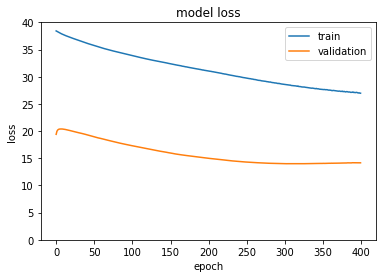

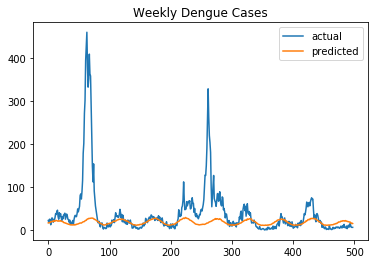

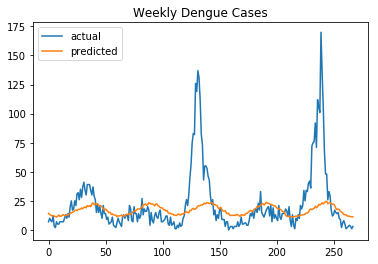

Forecast MAE: 14.298511729311587


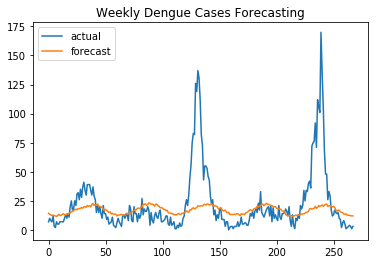

[14.291657,
 13.502465,
 12.869574,
 12.432518,
 12.79623,
 12.339457,
 12.008098,
 11.624023,
 12.371367,
 13.445407,
 12.323932,
 12.525594,
 13.261047,
 13.871179,
 13.009706,
 12.90679,
 13.874363,
 13.525061,
 14.36051,
 14.685522,
 15.546761,
 15.864922,
 16.500195,
 17.445442,
 17.857134,
 17.286684,
 18.310966,
 18.349092,
 18.49913,
 19.411121,
 18.608004,
 19.835407,
 20.128944,
 19.295156,
 21.095762,
 20.268858,
 20.752186,
 19.764185,
 22.002714,
 22.820013,
 21.106318,
 21.702795,
 21.251877,
 21.931038,
 20.44682,
 20.25228,
 19.979034,
 19.17511,
 17.880579,
 16.643587,
 17.693419,
 16.782595,
 15.842529,
 15.007759,
 15.540901,
 13.772339,
 14.226722,
 13.358897,
 13.461375,
 13.518971,
 12.061058,
 12.783946,
 12.743433,
 13.011537,
 13.45536,
 12.656694,
 13.127266,
 12.613594,
 14.108603,
 14.23996,
 13.923661,
 14.681989,
 14.02403,
 15.346072,
 16.096138,
 16.618378,
 17.219894,
 17.325953,
 18.70493,
 18.694984,
 18.438797,
 19.42862,
 19.831024,
 22.200891,
 21.

In [548]:
input_shape = (x.shape[1], x.shape[2])
model_sj = get_model_dense(input_shape)
train_model(model_sj, data, epochs=350)
plot_train_val(model_sj, data)
forecast_analysis(model_sj, data)

### Iquitos

In [535]:
train_split_percent = 0.65
lookback_window_iq = 150  # weeks.
df_iq = load_data(lookback_window_iq, city='iq')
x, y = format_data(df_iq, lookback_window_iq)
print(x.shape)
print(y.shape)

val_size = int(math.floor((len(x)*(1-train_split_percent))))
x_train, y_train, x_val, y_val = split(x, y, val_size)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
data = x_train, y_train, x_val, y_val

(370, 23, 150)
(370,)
(241, 23, 150)
(241,)
(129, 23, 150)
(129,)


(?, 23, 150)
Training...
Train on 241 samples, validate on 129 samples
Epoch 1/1500
 - 1s - loss: 6.8861 - val_loss: 8.8407
Epoch 2/1500
 - 0s - loss: 6.8448 - val_loss: 9.0417
Epoch 3/1500
 - 0s - loss: 6.8032 - val_loss: 9.1296
Epoch 4/1500
 - 0s - loss: 6.7623 - val_loss: 9.1805
Epoch 5/1500
 - 0s - loss: 6.7256 - val_loss: 9.2115
Epoch 6/1500
 - 0s - loss: 6.6867 - val_loss: 9.2291
Epoch 7/1500
 - 0s - loss: 6.6500 - val_loss: 9.2403
Epoch 8/1500
 - 0s - loss: 6.6181 - val_loss: 9.2497
Epoch 9/1500
 - 0s - loss: 6.5879 - val_loss: 9.2566
Epoch 10/1500
 - 0s - loss: 6.5587 - val_loss: 9.2639
Epoch 11/1500
 - 0s - loss: 6.5256 - val_loss: 9.2706
Epoch 12/1500
 - 0s - loss: 6.5092 - val_loss: 9.2734
Epoch 13/1500
 - 0s - loss: 6.4822 - val_loss: 9.2719
Epoch 14/1500
 - 0s - loss: 6.4649 - val_loss: 9.2668
Epoch 15/1500
 - 0s - loss: 6.4421 - val_loss: 9.2571
Epoch 16/1500
 - 0s - loss: 6.4211 - val_loss: 9.2456
Epoch 17/1500
 - 0s - loss: 6.3959 - val_loss: 9.2320
Epoch 18/1500
 - 0s 

Epoch 151/1500
 - 0s - loss: 5.0502 - val_loss: 8.3603
Epoch 152/1500
 - 0s - loss: 5.0493 - val_loss: 8.3568
Epoch 153/1500
 - 0s - loss: 5.0433 - val_loss: 8.3533
Epoch 154/1500
 - 0s - loss: 5.0348 - val_loss: 8.3511
Epoch 155/1500
 - 0s - loss: 5.0294 - val_loss: 8.3482
Epoch 156/1500
 - 0s - loss: 5.0296 - val_loss: 8.3458
Epoch 157/1500
 - 0s - loss: 5.0273 - val_loss: 8.3430
Epoch 158/1500
 - 0s - loss: 5.0249 - val_loss: 8.3403
Epoch 159/1500
 - 0s - loss: 5.0237 - val_loss: 8.3374
Epoch 160/1500
 - 0s - loss: 5.0160 - val_loss: 8.3349
Epoch 161/1500
 - 0s - loss: 5.0126 - val_loss: 8.3327
Epoch 162/1500
 - 0s - loss: 5.0130 - val_loss: 8.3294
Epoch 163/1500
 - 0s - loss: 5.0073 - val_loss: 8.3269
Epoch 164/1500
 - 0s - loss: 5.0065 - val_loss: 8.3246
Epoch 165/1500
 - 0s - loss: 5.0031 - val_loss: 8.3225
Epoch 166/1500
 - 0s - loss: 5.0003 - val_loss: 8.3194
Epoch 167/1500
 - 0s - loss: 4.9922 - val_loss: 8.3176
Epoch 168/1500
 - 0s - loss: 4.9914 - val_loss: 8.3152
Epoch 169/

Epoch 300/1500
 - 0s - loss: 4.7136 - val_loss: 8.0980
Epoch 301/1500
 - 0s - loss: 4.7111 - val_loss: 8.0989
Epoch 302/1500
 - 0s - loss: 4.7059 - val_loss: 8.1004
Epoch 303/1500
 - 0s - loss: 4.7043 - val_loss: 8.0996
Epoch 304/1500
 - 0s - loss: 4.7129 - val_loss: 8.0999
Epoch 305/1500
 - 0s - loss: 4.7061 - val_loss: 8.0977
Epoch 306/1500
 - 0s - loss: 4.7027 - val_loss: 8.0961
Epoch 307/1500
 - 0s - loss: 4.7024 - val_loss: 8.0967
Epoch 308/1500
 - 0s - loss: 4.6992 - val_loss: 8.0953
Epoch 309/1500
 - 0s - loss: 4.7025 - val_loss: 8.0960
Epoch 310/1500
 - 0s - loss: 4.6939 - val_loss: 8.0947
Epoch 311/1500
 - 0s - loss: 4.6970 - val_loss: 8.0929
Epoch 312/1500
 - 0s - loss: 4.7027 - val_loss: 8.0928
Epoch 313/1500
 - 0s - loss: 4.6952 - val_loss: 8.0941
Epoch 314/1500
 - 0s - loss: 4.6958 - val_loss: 8.0930
Epoch 315/1500
 - 0s - loss: 4.6851 - val_loss: 8.0926
Epoch 316/1500
 - 0s - loss: 4.6919 - val_loss: 8.0902
Epoch 317/1500
 - 0s - loss: 4.6851 - val_loss: 8.0883
Epoch 318/

Epoch 449/1500
 - 0s - loss: 4.5031 - val_loss: 7.9503
Epoch 450/1500
 - 0s - loss: 4.4916 - val_loss: 7.9501
Epoch 451/1500
 - 0s - loss: 4.4886 - val_loss: 7.9526
Epoch 452/1500
 - 0s - loss: 4.4929 - val_loss: 7.9492
Epoch 453/1500
 - 0s - loss: 4.4898 - val_loss: 7.9467
Epoch 454/1500
 - 0s - loss: 4.5024 - val_loss: 7.9468
Epoch 455/1500
 - 0s - loss: 4.4976 - val_loss: 7.9442
Epoch 456/1500
 - 0s - loss: 4.4892 - val_loss: 7.9437
Epoch 457/1500
 - 0s - loss: 4.4900 - val_loss: 7.9457
Epoch 458/1500
 - 0s - loss: 4.4894 - val_loss: 7.9448
Epoch 459/1500
 - 0s - loss: 4.4803 - val_loss: 7.9391
Epoch 460/1500
 - 0s - loss: 4.4849 - val_loss: 7.9379
Epoch 461/1500
 - 0s - loss: 4.4906 - val_loss: 7.9380
Epoch 462/1500
 - 0s - loss: 4.4936 - val_loss: 7.9347
Epoch 463/1500
 - 0s - loss: 4.4944 - val_loss: 7.9351
Epoch 464/1500
 - 0s - loss: 4.4874 - val_loss: 7.9378
Epoch 465/1500
 - 0s - loss: 4.4813 - val_loss: 7.9348
Epoch 466/1500
 - 0s - loss: 4.4797 - val_loss: 7.9352
Epoch 467/

Epoch 598/1500
 - 0s - loss: 4.2926 - val_loss: 7.8365
Epoch 599/1500
 - 0s - loss: 4.2977 - val_loss: 7.8318
Epoch 600/1500
 - 0s - loss: 4.2853 - val_loss: 7.8302
Epoch 601/1500
 - 0s - loss: 4.2916 - val_loss: 7.8325
Epoch 602/1500
 - 0s - loss: 4.2734 - val_loss: 7.8300
Epoch 603/1500
 - 0s - loss: 4.2820 - val_loss: 7.8310
Epoch 604/1500
 - 0s - loss: 4.2821 - val_loss: 7.8295
Epoch 605/1500
 - 0s - loss: 4.2800 - val_loss: 7.8296
Epoch 606/1500
 - 0s - loss: 4.2828 - val_loss: 7.8300
Epoch 607/1500
 - 0s - loss: 4.2703 - val_loss: 7.8317
Epoch 608/1500
 - 0s - loss: 4.2722 - val_loss: 7.8309
Epoch 609/1500
 - 0s - loss: 4.2686 - val_loss: 7.8298
Epoch 610/1500
 - 0s - loss: 4.2666 - val_loss: 7.8255
Epoch 611/1500
 - 0s - loss: 4.2851 - val_loss: 7.8198
Epoch 612/1500
 - 0s - loss: 4.2622 - val_loss: 7.8191
Epoch 613/1500
 - 0s - loss: 4.2887 - val_loss: 7.8216
Epoch 614/1500
 - 0s - loss: 4.2641 - val_loss: 7.8243
Epoch 615/1500
 - 0s - loss: 4.2523 - val_loss: 7.8275
Epoch 616/

Epoch 747/1500
 - 0s - loss: 4.0529 - val_loss: 7.7387
Epoch 748/1500
 - 0s - loss: 4.0381 - val_loss: 7.7367
Epoch 749/1500
 - 0s - loss: 4.0567 - val_loss: 7.7378
Epoch 750/1500
 - 0s - loss: 4.0318 - val_loss: 7.7373
Epoch 751/1500
 - 0s - loss: 4.0957 - val_loss: 7.7378
Epoch 752/1500
 - 0s - loss: 4.0577 - val_loss: 7.7386
Epoch 753/1500
 - 0s - loss: 4.0484 - val_loss: 7.7395
Epoch 754/1500
 - 0s - loss: 4.0340 - val_loss: 7.7373
Epoch 755/1500
 - 0s - loss: 4.0593 - val_loss: 7.7369
Epoch 756/1500
 - 0s - loss: 4.0243 - val_loss: 7.7367
Epoch 757/1500
 - 0s - loss: 4.0346 - val_loss: 7.7371
Epoch 758/1500
 - 0s - loss: 4.0716 - val_loss: 7.7368
Epoch 759/1500
 - 0s - loss: 4.0047 - val_loss: 7.7345
Epoch 760/1500
 - 0s - loss: 4.0309 - val_loss: 7.7326
Epoch 761/1500
 - 0s - loss: 4.0262 - val_loss: 7.7322
Epoch 762/1500
 - 0s - loss: 4.0357 - val_loss: 7.7314
Epoch 763/1500
 - 0s - loss: 4.0647 - val_loss: 7.7305
Epoch 764/1500
 - 0s - loss: 4.0340 - val_loss: 7.7317
Epoch 765/

Epoch 896/1500
 - 0s - loss: 3.7865 - val_loss: 7.6808
Epoch 897/1500
 - 0s - loss: 3.8405 - val_loss: 7.6802
Epoch 898/1500
 - 0s - loss: 3.7911 - val_loss: 7.6809
Epoch 899/1500
 - 0s - loss: 3.8559 - val_loss: 7.6811
Epoch 900/1500
 - 0s - loss: 3.8527 - val_loss: 7.6793
Epoch 901/1500
 - 0s - loss: 3.7718 - val_loss: 7.6778
Epoch 902/1500
 - 0s - loss: 3.7735 - val_loss: 7.6771
Epoch 903/1500
 - 0s - loss: 3.7760 - val_loss: 7.6776
Epoch 904/1500
 - 0s - loss: 3.7585 - val_loss: 7.6774
Epoch 905/1500
 - 0s - loss: 3.7901 - val_loss: 7.6773
Epoch 906/1500
 - 0s - loss: 3.7571 - val_loss: 7.6769
Epoch 907/1500
 - 0s - loss: 3.8017 - val_loss: 7.6767
Epoch 908/1500
 - 0s - loss: 3.7517 - val_loss: 7.6769
Epoch 909/1500
 - 0s - loss: 3.7539 - val_loss: 7.6761
Epoch 910/1500
 - 0s - loss: 3.7585 - val_loss: 7.6755
Epoch 911/1500
 - 0s - loss: 3.7624 - val_loss: 7.6753
Epoch 912/1500
 - 0s - loss: 3.7800 - val_loss: 7.6756
Epoch 913/1500
 - 0s - loss: 3.7856 - val_loss: 7.6755
Epoch 914/

 - 0s - loss: 3.6021 - val_loss: 7.6437
Epoch 1045/1500
 - 0s - loss: 3.5313 - val_loss: 7.6447
Epoch 1046/1500
 - 0s - loss: 3.5484 - val_loss: 7.6444
Epoch 1047/1500
 - 0s - loss: 3.5520 - val_loss: 7.6440
Epoch 1048/1500
 - 0s - loss: 3.5420 - val_loss: 7.6433
Epoch 1049/1500
 - 0s - loss: 3.5349 - val_loss: 7.6435
Epoch 1050/1500
 - 0s - loss: 3.5534 - val_loss: 7.6423
Epoch 1051/1500
 - 0s - loss: 3.5905 - val_loss: 7.6412
Epoch 1052/1500
 - 0s - loss: 3.5669 - val_loss: 7.6408
Epoch 1053/1500
 - 0s - loss: 3.5191 - val_loss: 7.6403
Epoch 1054/1500
 - 0s - loss: 3.5379 - val_loss: 7.6404
Epoch 1055/1500
 - 0s - loss: 3.5784 - val_loss: 7.6408
Epoch 1056/1500
 - 0s - loss: 3.5471 - val_loss: 7.6412
Epoch 1057/1500
 - 0s - loss: 3.5620 - val_loss: 7.6400
Epoch 1058/1500
 - 0s - loss: 3.5319 - val_loss: 7.6409
Epoch 1059/1500
 - 0s - loss: 3.5352 - val_loss: 7.6415
Epoch 1060/1500
 - 0s - loss: 3.5173 - val_loss: 7.6416
Epoch 1061/1500
 - 0s - loss: 3.5456 - val_loss: 7.6416
Epoch 10

Epoch 1191/1500
 - 0s - loss: 3.3703 - val_loss: 7.6304
Epoch 1192/1500
 - 0s - loss: 3.3830 - val_loss: 7.6299
Epoch 1193/1500
 - 0s - loss: 3.3125 - val_loss: 7.6298
Epoch 1194/1500
 - 0s - loss: 3.3496 - val_loss: 7.6295
Epoch 1195/1500
 - 0s - loss: 3.3126 - val_loss: 7.6296
Epoch 1196/1500
 - 0s - loss: 3.3504 - val_loss: 7.6297
Epoch 1197/1500
 - 0s - loss: 3.3369 - val_loss: 7.6305
Epoch 1198/1500
 - 0s - loss: 3.3645 - val_loss: 7.6301
Epoch 1199/1500
 - 0s - loss: 3.3756 - val_loss: 7.6298
Epoch 1200/1500
 - 0s - loss: 3.2933 - val_loss: 7.6294
Epoch 1201/1500
 - 0s - loss: 3.3285 - val_loss: 7.6287
Epoch 1202/1500
 - 0s - loss: 3.3859 - val_loss: 7.6279
Epoch 1203/1500
 - 0s - loss: 3.2983 - val_loss: 7.6285
Epoch 1204/1500
 - 0s - loss: 3.3711 - val_loss: 7.6289
Epoch 1205/1500
 - 0s - loss: 3.2955 - val_loss: 7.6289
Epoch 1206/1500
 - 0s - loss: 3.2899 - val_loss: 7.6288
Epoch 1207/1500
 - 0s - loss: 3.3328 - val_loss: 7.6285
Epoch 1208/1500
 - 0s - loss: 3.4150 - val_loss:

Epoch 1338/1500
 - 0s - loss: 3.1337 - val_loss: 7.6212
Epoch 1339/1500
 - 0s - loss: 3.1643 - val_loss: 7.6211
Epoch 1340/1500
 - 0s - loss: 3.1201 - val_loss: 7.6209
Epoch 1341/1500
 - 0s - loss: 3.1339 - val_loss: 7.6202
Epoch 1342/1500
 - 0s - loss: 3.1295 - val_loss: 7.6195
Epoch 1343/1500
 - 0s - loss: 3.1288 - val_loss: 7.6196
Epoch 1344/1500
 - 0s - loss: 3.1170 - val_loss: 7.6198
Epoch 1345/1500
 - 0s - loss: 3.1334 - val_loss: 7.6194
Epoch 1346/1500
 - 0s - loss: 3.1200 - val_loss: 7.6194
Epoch 1347/1500
 - 0s - loss: 3.1711 - val_loss: 7.6193
Epoch 1348/1500
 - 0s - loss: 3.1410 - val_loss: 7.6199
Epoch 1349/1500
 - 0s - loss: 3.1421 - val_loss: 7.6203
Epoch 1350/1500
 - 0s - loss: 3.1216 - val_loss: 7.6207
Epoch 1351/1500
 - 0s - loss: 3.1458 - val_loss: 7.6205
Epoch 1352/1500
 - 0s - loss: 3.0992 - val_loss: 7.6207
Epoch 1353/1500
 - 0s - loss: 3.1594 - val_loss: 7.6206
Epoch 1354/1500
 - 0s - loss: 3.0904 - val_loss: 7.6207
Epoch 1355/1500
 - 0s - loss: 3.1113 - val_loss:

Epoch 1485/1500
 - 0s - loss: 2.9932 - val_loss: 7.6179
Epoch 1486/1500
 - 0s - loss: 2.9872 - val_loss: 7.6179
Epoch 1487/1500
 - 0s - loss: 2.9655 - val_loss: 7.6181
Epoch 1488/1500
 - 0s - loss: 2.9246 - val_loss: 7.6185
Epoch 1489/1500
 - 0s - loss: 3.0356 - val_loss: 7.6185
Epoch 1490/1500
 - 0s - loss: 2.9522 - val_loss: 7.6181
Epoch 1491/1500
 - 0s - loss: 2.9560 - val_loss: 7.6181
Epoch 1492/1500
 - 0s - loss: 2.9608 - val_loss: 7.6178
Epoch 1493/1500
 - 0s - loss: 2.9712 - val_loss: 7.6185
Epoch 1494/1500
 - 0s - loss: 3.0245 - val_loss: 7.6187
Epoch 1495/1500
 - 0s - loss: 2.9897 - val_loss: 7.6188
Epoch 1496/1500
 - 0s - loss: 2.9643 - val_loss: 7.6191
Epoch 1497/1500
 - 0s - loss: 3.0275 - val_loss: 7.6188
Epoch 1498/1500
 - 0s - loss: 2.9978 - val_loss: 7.6185
Epoch 1499/1500
 - 0s - loss: 3.0037 - val_loss: 7.6182
Epoch 1500/1500
 - 0s - loss: 2.9220 - val_loss: 7.6186
Elapsed Time: 170.03262662887573


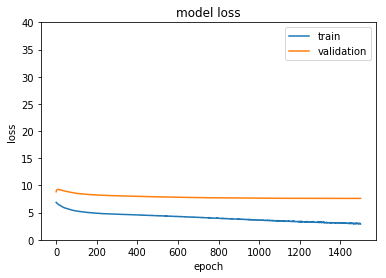

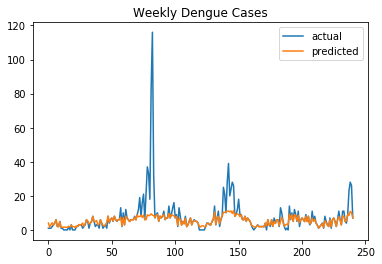

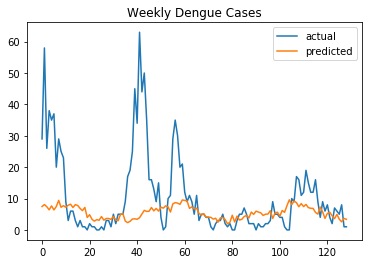

Forecast MAE: 7.651869600133378


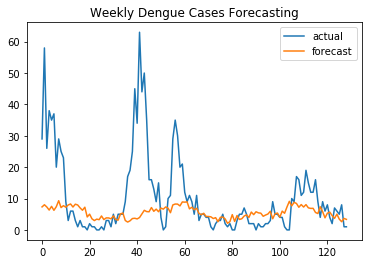

[7.33441,
 8.022617,
 7.309886,
 6.329014,
 7.511424,
 6.2479773,
 7.41097,
 9.311725,
 7.1147175,
 7.726946,
 7.2318153,
 7.9497237,
 8.267566,
 7.294896,
 8.196931,
 7.9427576,
 7.0183473,
 6.275362,
 7.2345023,
 4.1353726,
 5.0188036,
 3.534321,
 2.9801025,
 3.4371958,
 3.2637303,
 4.446315,
 3.2920744,
 3.833351,
 3.820081,
 3.5406005,
 4.4605117,
 3.3073723,
 3.1248596,
 5.1083093,
 5.3750224,
 3.001297,
 2.5017052,
 2.9022403,
 3.6266057,
 3.712559,
 3.50834,
 3.9440017,
 5.0979633,
 6.245755,
 5.8443756,
 5.781241,
 7.126523,
 5.9331145,
 6.625427,
 5.795027,
 6.95997,
 6.6224427,
 7.3198495,
 6.9365306,
 5.489233,
 7.9604917,
 8.24837,
 8.229832,
 7.6505513,
 8.915328,
 8.848165,
 8.936761,
 6.713882,
 7.210934,
 6.4230213,
 6.9008026,
 5.265219,
 4.8464694,
 5.300427,
 4.296606,
 4.280698,
 4.1764092,
 3.6253188,
 3.9066575,
 2.6206772,
 4.030238,
 4.11046,
 3.504053,
 2.124091,
 2.6186206,
 4.8673754,
 2.7056456,
 4.581147,
 3.335745,
 3.5578501,
 4.429315,
 4.79637,
 3.97365

In [541]:
input_shape = (x.shape[1], x.shape[2])
model_iq = get_model_dense(input_shape)
train_model(model_iq, data, epochs=1500)
plot_train_val(model_iq, data)
forecast_analysis(model_iq, data)

## Model / Train / Forecast - TimeDistributed Model

In [549]:
K.clear_session()

### San Juan

In [550]:
train_split_percent = 0.65
lookback_window_sj = 170  # weeks.
df_sj = load_data(lookback_window_sj, city='sj')


x, y = format_data(df_sj, lookback_window_sj)
print(x.shape)
print(y.shape)


val_size = int(math.floor((len(x)*(1-train_split_percent))))
x_train, y_train, x_val, y_val = split(x, y, val_size)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

data = x_train, y_train, x_val, y_val

(766, 23, 170)
(766,)
(498, 23, 170)
(498,)
(268, 23, 170)
(268,)


(?, 23, 170)
Training...
Train on 498 samples, validate on 268 samples
Epoch 1/350
 - 1s - loss: 38.8993 - val_loss: 21.8378
Epoch 2/350
 - 0s - loss: 38.8455 - val_loss: 21.8308
Epoch 3/350
 - 0s - loss: 38.7968 - val_loss: 21.8006
Epoch 4/350
 - 0s - loss: 38.7476 - val_loss: 21.7661
Epoch 5/350
 - 0s - loss: 38.7049 - val_loss: 21.7268
Epoch 6/350
 - 0s - loss: 38.6576 - val_loss: 21.6834
Epoch 7/350
 - 0s - loss: 38.6147 - val_loss: 21.6380
Epoch 8/350
 - 0s - loss: 38.5729 - val_loss: 21.5918
Epoch 9/350
 - 0s - loss: 38.5310 - val_loss: 21.5446
Epoch 10/350
 - 0s - loss: 38.4863 - val_loss: 21.4970
Epoch 11/350
 - 0s - loss: 38.4429 - val_loss: 21.4492
Epoch 12/350
 - 0s - loss: 38.3976 - val_loss: 21.4012
Epoch 13/350
 - 0s - loss: 38.3487 - val_loss: 21.3532
Epoch 14/350
 - 0s - loss: 38.3044 - val_loss: 21.3052
Epoch 15/350
 - 0s - loss: 38.2614 - val_loss: 21.2572
Epoch 16/350
 - 0s - loss: 38.2192 - val_loss: 21.2095
Epoch 17/350
 - 0s - loss: 38.1679 - val_loss: 21.1619
Epo

Epoch 148/350
 - 0s - loss: 33.2459 - val_loss: 16.5583
Epoch 149/350
 - 0s - loss: 33.2190 - val_loss: 16.5324
Epoch 150/350
 - 0s - loss: 33.1884 - val_loss: 16.5074
Epoch 151/350
 - 0s - loss: 33.1560 - val_loss: 16.4813
Epoch 152/350
 - 0s - loss: 33.1302 - val_loss: 16.4561
Epoch 153/350
 - 0s - loss: 33.1070 - val_loss: 16.4306
Epoch 154/350
 - 0s - loss: 33.0778 - val_loss: 16.4062
Epoch 155/350
 - 0s - loss: 33.0524 - val_loss: 16.3822
Epoch 156/350
 - 0s - loss: 33.0276 - val_loss: 16.3581
Epoch 157/350
 - 0s - loss: 32.9942 - val_loss: 16.3353
Epoch 158/350
 - 0s - loss: 32.9674 - val_loss: 16.3121
Epoch 159/350
 - 0s - loss: 32.9447 - val_loss: 16.2897
Epoch 160/350
 - 0s - loss: 32.9174 - val_loss: 16.2672
Epoch 161/350
 - 0s - loss: 32.8894 - val_loss: 16.2451
Epoch 162/350
 - 0s - loss: 32.8592 - val_loss: 16.2228
Epoch 163/350
 - 0s - loss: 32.8269 - val_loss: 16.1996
Epoch 164/350
 - 0s - loss: 32.7928 - val_loss: 16.1771
Epoch 165/350
 - 0s - loss: 32.7693 - val_loss: 

Epoch 295/350
 - 0s - loss: 29.3188 - val_loss: 14.1564
Epoch 296/350
 - 0s - loss: 29.2938 - val_loss: 14.1478
Epoch 297/350
 - 0s - loss: 29.3014 - val_loss: 14.1398
Epoch 298/350
 - 0s - loss: 29.2722 - val_loss: 14.1326
Epoch 299/350
 - 0s - loss: 29.2229 - val_loss: 14.1248
Epoch 300/350
 - 0s - loss: 29.1996 - val_loss: 14.1173
Epoch 301/350
 - 0s - loss: 29.1954 - val_loss: 14.1096
Epoch 302/350
 - 0s - loss: 29.1285 - val_loss: 14.1024
Epoch 303/350
 - 0s - loss: 29.1146 - val_loss: 14.0948
Epoch 304/350
 - 0s - loss: 29.0987 - val_loss: 14.0885
Epoch 305/350
 - 0s - loss: 29.0602 - val_loss: 14.0821
Epoch 306/350
 - 0s - loss: 29.0573 - val_loss: 14.0755
Epoch 307/350
 - 0s - loss: 29.0293 - val_loss: 14.0694
Epoch 308/350
 - 0s - loss: 29.0233 - val_loss: 14.0629
Epoch 309/350
 - 0s - loss: 28.9581 - val_loss: 14.0562
Epoch 310/350
 - 0s - loss: 28.9409 - val_loss: 14.0499
Epoch 311/350
 - 0s - loss: 28.9280 - val_loss: 14.0447
Epoch 312/350
 - 0s - loss: 28.9144 - val_loss: 

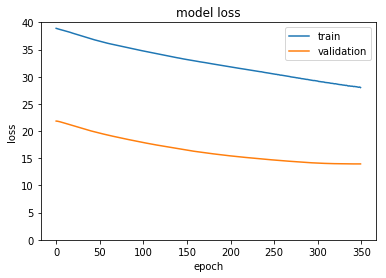

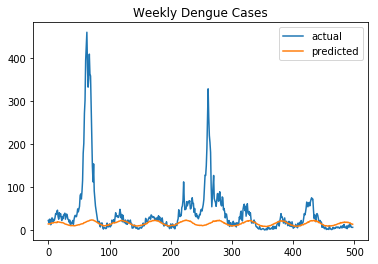

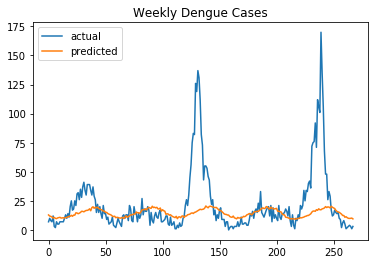

Forecast MAE: 14.067045265169286


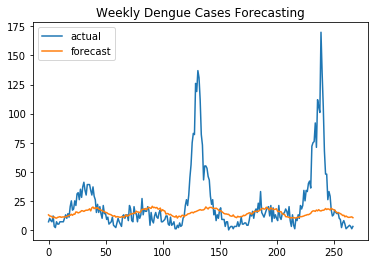

[12.93457,
 11.996908,
 11.819878,
 11.312601,
 10.368047,
 11.146745,
 10.340837,
 10.146173,
 10.821143,
 11.075059,
 11.430136,
 10.83885,
 11.07228,
 11.199781,
 10.958695,
 11.327948,
 11.693784,
 12.015595,
 12.6136,
 12.555366,
 13.435268,
 12.5599575,
 13.62489,
 13.451572,
 15.455695,
 15.295686,
 14.59625,
 15.026069,
 15.598253,
 16.577225,
 16.40463,
 15.900481,
 16.579435,
 16.975742,
 16.944965,
 17.255285,
 18.131388,
 16.383614,
 19.016514,
 19.684982,
 18.243305,
 19.187365,
 18.555542,
 19.201027,
 17.940945,
 17.588196,
 16.99613,
 16.698746,
 15.8509035,
 15.887108,
 14.887069,
 14.946093,
 14.05478,
 13.601874,
 13.337389,
 12.9380865,
 12.155874,
 11.857791,
 12.25113,
 10.994257,
 11.473658,
 11.294956,
 11.00947,
 10.874177,
 11.166172,
 11.605276,
 10.585807,
 11.818681,
 13.075447,
 11.632073,
 12.407043,
 12.866984,
 13.744538,
 13.69515,
 14.116938,
 14.504289,
 14.3727255,
 16.066925,
 15.408709,
 15.345608,
 14.779655,
 16.024935,
 17.588432,
 17.855566,
 

In [552]:
input_shape = (x.shape[1], x.shape[2])
model_iq = get_model_timedist(input_shape)
train_model(model_iq, data, epochs=350)
plot_train_val(model_iq, data)
forecast_analysis(model_iq, data)

### Iquitos

In [553]:
train_split_percent = 0.65
lookback_window_iq = 150  # weeks.
df_iq = load_data(lookback_window_iq, city='iq')
x, y = format_data(df_iq, lookback_window_iq)
print(x.shape)
print(y.shape)

val_size = int(math.floor((len(x)*(1-train_split_percent))))
x_train, y_train, x_val, y_val = split(x, y, val_size)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
data = x_train, y_train, x_val, y_val

(370, 23, 150)
(370,)
(241, 23, 150)
(241,)
(129, 23, 150)
(129,)


(?, 23, 150)
Training...
Train on 241 samples, validate on 129 samples
Epoch 1/600
 - 1s - loss: 7.4483 - val_loss: 10.2301
Epoch 2/600
 - 0s - loss: 7.4427 - val_loss: 10.2494
Epoch 3/600
 - 0s - loss: 7.4356 - val_loss: 10.2558
Epoch 4/600
 - 0s - loss: 7.4279 - val_loss: 10.2568
Epoch 5/600
 - 0s - loss: 7.4178 - val_loss: 10.2551
Epoch 6/600
 - 0s - loss: 7.4116 - val_loss: 10.2512
Epoch 7/600
 - 0s - loss: 7.4011 - val_loss: 10.2454
Epoch 8/600
 - 0s - loss: 7.3879 - val_loss: 10.2383
Epoch 9/600
 - 0s - loss: 7.3733 - val_loss: 10.2302
Epoch 10/600
 - 0s - loss: 7.3593 - val_loss: 10.2211
Epoch 11/600
 - 0s - loss: 7.3430 - val_loss: 10.2103
Epoch 12/600
 - 0s - loss: 7.3229 - val_loss: 10.1966
Epoch 13/600
 - 0s - loss: 7.2986 - val_loss: 10.1821
Epoch 14/600
 - 0s - loss: 7.2708 - val_loss: 10.1656
Epoch 15/600
 - 0s - loss: 7.2333 - val_loss: 10.1475
Epoch 16/600
 - 0s - loss: 7.1984 - val_loss: 10.1285
Epoch 17/600
 - 0s - loss: 7.1668 - val_loss: 10.1092
Epoch 18/600
 - 0s -

Epoch 153/600
 - 0s - loss: 5.3501 - val_loss: 8.5747
Epoch 154/600
 - 0s - loss: 5.3444 - val_loss: 8.5695
Epoch 155/600
 - 0s - loss: 5.3444 - val_loss: 8.5646
Epoch 156/600
 - 0s - loss: 5.3408 - val_loss: 8.5598
Epoch 157/600
 - 0s - loss: 5.3310 - val_loss: 8.5554
Epoch 158/600
 - 0s - loss: 5.3203 - val_loss: 8.5506
Epoch 159/600
 - 0s - loss: 5.3103 - val_loss: 8.5458
Epoch 160/600
 - 0s - loss: 5.3161 - val_loss: 8.5410
Epoch 161/600
 - 0s - loss: 5.3067 - val_loss: 8.5362
Epoch 162/600
 - 0s - loss: 5.3012 - val_loss: 8.5315
Epoch 163/600
 - 0s - loss: 5.3046 - val_loss: 8.5268
Epoch 164/600
 - 0s - loss: 5.2977 - val_loss: 8.5222
Epoch 165/600
 - 0s - loss: 5.2944 - val_loss: 8.5175
Epoch 166/600
 - 0s - loss: 5.2873 - val_loss: 8.5129
Epoch 167/600
 - 0s - loss: 5.2850 - val_loss: 8.5083
Epoch 168/600
 - 0s - loss: 5.2802 - val_loss: 8.5038
Epoch 169/600
 - 0s - loss: 5.2716 - val_loss: 8.4992
Epoch 170/600
 - 0s - loss: 5.2695 - val_loss: 8.4947
Epoch 171/600
 - 0s - loss: 

Epoch 305/600
 - 0s - loss: 4.7937 - val_loss: 8.1064
Epoch 306/600
 - 0s - loss: 4.7911 - val_loss: 8.1047
Epoch 307/600
 - 0s - loss: 4.7922 - val_loss: 8.1031
Epoch 308/600
 - 0s - loss: 4.7803 - val_loss: 8.1015
Epoch 309/600
 - 0s - loss: 4.7833 - val_loss: 8.0998
Epoch 310/600
 - 0s - loss: 4.7787 - val_loss: 8.0982
Epoch 311/600
 - 0s - loss: 4.7785 - val_loss: 8.0966
Epoch 312/600
 - 0s - loss: 4.7782 - val_loss: 8.0950
Epoch 313/600
 - 0s - loss: 4.7850 - val_loss: 8.0935
Epoch 314/600
 - 0s - loss: 4.7775 - val_loss: 8.0920
Epoch 315/600
 - 0s - loss: 4.7708 - val_loss: 8.0905
Epoch 316/600
 - 0s - loss: 4.7716 - val_loss: 8.0888
Epoch 317/600
 - 0s - loss: 4.7730 - val_loss: 8.0873
Epoch 318/600
 - 0s - loss: 4.7625 - val_loss: 8.0859
Epoch 319/600
 - 0s - loss: 4.7608 - val_loss: 8.0844
Epoch 320/600
 - 0s - loss: 4.7686 - val_loss: 8.0827
Epoch 321/600
 - 0s - loss: 4.7652 - val_loss: 8.0810
Epoch 322/600
 - 0s - loss: 4.7608 - val_loss: 8.0795
Epoch 323/600
 - 0s - loss: 

Epoch 457/600
 - 0s - loss: 4.5122 - val_loss: 7.9095
Epoch 458/600
 - 0s - loss: 4.5092 - val_loss: 7.9085
Epoch 459/600
 - 0s - loss: 4.5077 - val_loss: 7.9075
Epoch 460/600
 - 0s - loss: 4.5044 - val_loss: 7.9064
Epoch 461/600
 - 0s - loss: 4.5034 - val_loss: 7.9052
Epoch 462/600
 - 0s - loss: 4.5056 - val_loss: 7.9041
Epoch 463/600
 - 0s - loss: 4.5214 - val_loss: 7.9031
Epoch 464/600
 - 0s - loss: 4.4941 - val_loss: 7.9022
Epoch 465/600
 - 0s - loss: 4.4877 - val_loss: 7.9011
Epoch 466/600
 - 0s - loss: 4.5014 - val_loss: 7.9000
Epoch 467/600
 - 0s - loss: 4.4880 - val_loss: 7.8991
Epoch 468/600
 - 0s - loss: 4.4932 - val_loss: 7.8984
Epoch 469/600
 - 0s - loss: 4.4897 - val_loss: 7.8976
Epoch 470/600
 - 0s - loss: 4.5042 - val_loss: 7.8966
Epoch 471/600
 - 0s - loss: 4.4900 - val_loss: 7.8955
Epoch 472/600
 - 0s - loss: 4.4807 - val_loss: 7.8944
Epoch 473/600
 - 0s - loss: 4.4835 - val_loss: 7.8933
Epoch 474/600
 - 0s - loss: 4.5236 - val_loss: 7.8923
Epoch 475/600
 - 0s - loss: 

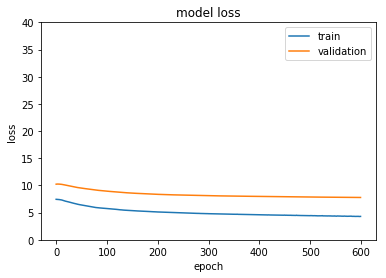

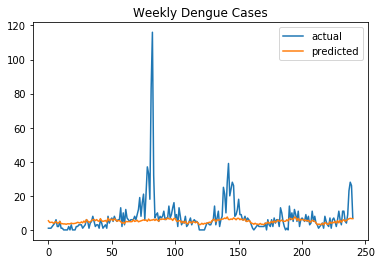

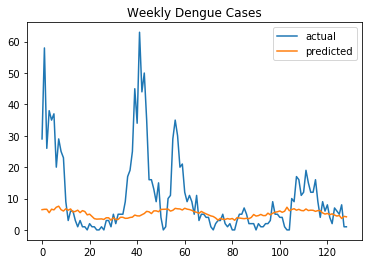

Forecast MAE: 7.828297910764236


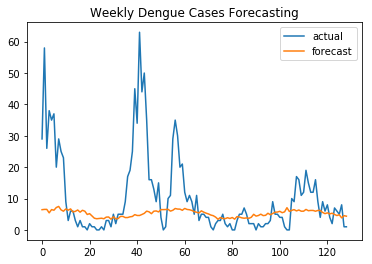

[6.4460807,
 6.5411677,
 6.542933,
 5.442959,
 6.478621,
 6.2748957,
 7.142017,
 7.484405,
 6.3829503,
 5.9619274,
 6.683441,
 6.28425,
 6.6959987,
 5.724128,
 5.918666,
 6.3484926,
 5.6551332,
 6.258865,
 5.9577837,
 4.923139,
 5.184055,
 4.472621,
 3.7298033,
 3.5595882,
 3.6558924,
 3.7305,
 3.560709,
 4.0786815,
 4.118534,
 3.4218776,
 4.1738577,
 3.54529,
 3.6145737,
 4.3086233,
 4.310443,
 3.934366,
 3.9428332,
 4.173604,
 4.2900167,
 4.874751,
 4.6039376,
 4.598179,
 4.9177294,
 5.281441,
 5.9867754,
 5.7638783,
 5.1715326,
 5.964662,
 6.046922,
 5.7435317,
 6.472838,
 6.468145,
 6.502345,
 6.5726504,
 5.984446,
 6.261653,
 6.8262672,
 6.647794,
 6.6204767,
 6.2539787,
 6.850406,
 6.526669,
 6.433055,
 6.206092,
 5.8312087,
 5.6150684,
 5.41668,
 6.070543,
 5.663822,
 5.3377905,
 5.08749,
 4.7357016,
 4.5360136,
 4.079123,
 3.3862371,
 3.9655948,
 3.643482,
 3.5808935,
 3.8874776,
 3.640144,
 3.955997,
 3.4273667,
 4.2521205,
 4.099151,
 3.8490348,
 3.7216332,
 3.8268414,
 3.696

In [554]:
input_shape = (x.shape[1], x.shape[2])
model_iq = get_model_timedist(input_shape)
train_model(model_iq, data, epochs=600)
plot_train_val(model_iq, data)
forecast_analysis(model_iq, data)